<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Brief-EDA-and-Merge" data-toc-modified-id="Brief-EDA-and-Merge-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Brief EDA and Merge</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Time-Formatting-and-Sort" data-toc-modified-id="Time-Formatting-and-Sort-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Time Formatting and Sort</a></span></li><li><span><a href="#Addition-of-'Pass'-Column" data-toc-modified-id="Addition-of-'Pass'-Column-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Addition of 'Pass' Column</a></span></li></ul></li></ul></li><li><span><a href="#Dealing-with-Multiple-User-Attempts" data-toc-modified-id="Dealing-with-Multiple-User-Attempts-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dealing with Multiple User Attempts</a></span></li><li><span><a href="#Analysis-of-the-Document-Report-Field:-'Properties'" data-toc-modified-id="Analysis-of-the-Document-Report-Field:-'Properties'-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis of the Document Report Field: 'Properties'</a></span></li><li><span><a href="#Null-results" data-toc-modified-id="Null-results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Null results</a></span></li></ul></div>

# Revolut Challenge: Investigation into the Reduction of the 'Know Your Customer' Pass Rate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import ast
plt.rcParams['figure.figsize'] = (30, 15)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 22})

In [2]:
df_docs = pd.read_csv("data/doc_reports.csv")
df_face = pd.read_csv("data/facial_similarity_reports.csv")

## Brief EDA and Merge

In [3]:
df_docs['user_id'].equals(df_face['user_id'])  # 'user_id' is identical

True

In [4]:
# False for 'attempt_id'—why?
df_docs['attempt_id'].equals(df_face['attempt_id'])

False

In [5]:
doc_id = df_docs['attempt_id']
f_id = df_face['attempt_id']
for i in range(len(df_docs)):
    if doc_id[i] != f_id[i]:
        print('index: {}, doc_id: {}, face_id: {}'.format(
            i, doc_id[i], f_id[i]))
# one value, float formatting aberrant, safe to merge

index: 168513, doc_id: 9.6949E+31, face_id: 96948966045741509980950989095520


In [6]:
# Merge
df = df_face.merge(df_docs, on=df_face.index,)
df = df.drop(['key_0'], 1)

In [7]:
# Remove other columns that are duplicated in both files, and rename columns of new df
duplicated = set()
for column in df.columns:
    if "_x" in column or "_y" in column:
        name = column.replace("_x", "")
        name = name.replace("_y", "")
        duplicated.add(name)


def compare_columns(column, df):
    return df[column + "_x"].equals(df[column + "_y"])


for name in duplicated:
    face_col = name + "_x"
    docs_col = name + "_y"
    if compare_columns(name, df):
        # then remove repeated columns and rename them
        df.rename({face_col: name}, axis=1, inplace=True)
        df.drop(docs_col, inplace=True, axis=1)
    else:
        df.rename({face_col: "FACE_" + name, docs_col: "DOCS_" +
                   name}, axis=1, inplace=True)
# only 'unnamed' duplicated, I suspect the original index from a larger data set
# as index extends to 181991 rather than the 176403 attempts

#### Time Formatting and Sort

In [8]:
# change format of dates so parsable with pandas
df["FACE_created_at"] = pd.to_datetime(df["FACE_created_at"])
df["DOCS_created_at"] = pd.to_datetime(df["DOCS_created_at"])

In [9]:
# Investigate disparity of creation times of the Document and Facial Checks
creation_time_diff = df["FACE_created_at"] - df["DOCS_created_at"]
creation_time_diff = pd.Series([i.total_seconds() for i in creation_time_diff])
creation_time_diff.value_counts()

 0.0    167121
 1.0      5775
-1.0      3507
-4.0         1
dtype: int64

In [10]:
# One anomaly.
# For others I assume this time relates to API processing time and is a fraction of a second,
#and where a second, just on the cusp of a new second, still same processing time.
# Although, the Document check is created first, more often

In [11]:
# Order the dataframe in terms of time
df.sort_values(["FACE_created_at"], inplace=True)
df.reset_index(drop=True,inplace=True)

#### Addition of 'Pass' Column

In [12]:
# An Attempt is successful if the results of both the Document and Facial Similarity checks are ‘clear’.

# True for Facial Similarity Check result of 'clear'
face_result = df["FACE_result"] == "clear"
# True for Document Check result of 'clear'
docs_result = df["DOCS_result"] == "clear"

df['Pass'] = face_result & docs_result
# Pass column denotes if face_result and docs_result True => that attempt passsed KYC
df.iloc[0, :]

Unnamed: 0                                                                        49293
user_id                                                3aee7324dfba466d96888ff9ad185b58
FACE_result                                                                       clear
face_comparison_result                                                            clear
FACE_created_at                                                     2017-05-23 15:13:02
facial_image_integrity_result                                                     clear
visual_authenticity_result                                                        clear
FACE_properties                                                         {'score': 0.73}
FACE_attempt_id                                        d21de828c5514277aaedb316edc6c48c
DOCS_result                                                                       clear
image_integrity_result                                                            clear
face_detection_result           

## Dealing with Multiple User Attempts

In [13]:
# The pass rate is defined as the number of customers who pass both the KYC processes
# divided by the number of customers who attempt the overall process.
# Each customer has up to 2 attempts
# Therefore to calculate an accurate pass rate, one has to take the best result of the
# first two attempts
only_one_attempt_users = df.drop_duplicates('user_id', False)
only_one_attempt_users.shape  # majority of users only attempted once.

(110374, 26)

In [14]:
user_attempt_counts = df['user_id'].value_counts()
user_attempt_counts.head()  # some users had more than 2 attempts
user_attempt_counts[user_attempt_counts > 2].head()  # only 1232

6eeb7dbdf1fa4e7c95413bc0608dd21c    6
2df96cd3537d415a9e7f23f419197187    6
7b83073845604ea3acb150e421977537    5
d3aa9ff3437a4ade990805eeb01bba2b    5
79c7b0bab8d54d3cb9b2eaccef744c9d    5
Name: user_id, dtype: int64

In [15]:
# df of only multiple user attempts
df_multiple_attempt = df[df.duplicated('user_id', keep=False)]

df_ma_1st = df_multiple_attempt.drop_duplicates(
    'user_id', 'first')  # 1st attempt of these users
df_ma_final = df_multiple_attempt.drop_duplicates(
    'user_id', 'last')  # Final attempt of these users

# 5031 users passed their first attempt, but retried
df_ma_passed1st = df_ma_1st[df_ma_1st["Pass"]]

In [16]:
df_ma_failed_first = df_ma_1st[df_ma_1st['Pass'] == False]
# df of multiple attempt users who failed 1st attempt
df_2nd_attempt_only = df_multiple_attempt.groupby(
    ['user_id']).head(2).groupby(['user_id']).tail(1)
# df of only the 2nd attempt of multiple attempt users
df_1stattempts_only = df.drop_duplicates('user_id', 'first')
# df of only the 1st attempts of all user

In [17]:
s1 = pd.concat([df_ma_failed_first, df_2nd_attempt_only])
s1 = s1.drop_duplicates('user_id', 'last')
# keeping only 2nd attempt  of users, who had multiple attempts but failed the first
s2 = pd.concat([df_1stattempts_only, s1])
s2 = s2.drop_duplicates('user_id', 'last')
# Reorganising so have only 2nd attempt of users who had multiple attempts but failed the first
# and first attempt of all other users so an accurate pass rate can be caluclated
df_pass_rate = s2.sort_values(["FACE_created_at"])
df_pass_rate.reset_index(drop=True, inplace=True)
#df_pass_rate

In [18]:
len(df.drop_duplicates('user_id','first'))/len(df) # ≈ 80% of attempts are not repeat attempts

# Using 'df_pass_rate' cf. 'df' does not change trend outcomes so I am choosing to use 'df' to 
#have more data points to analyse why the pass rate has decreased. I ran the notebook with df_pass_rate as well,
# and there were no changes to the conclusions.



0.8090746241581823

# Increase in Attempts Per Day

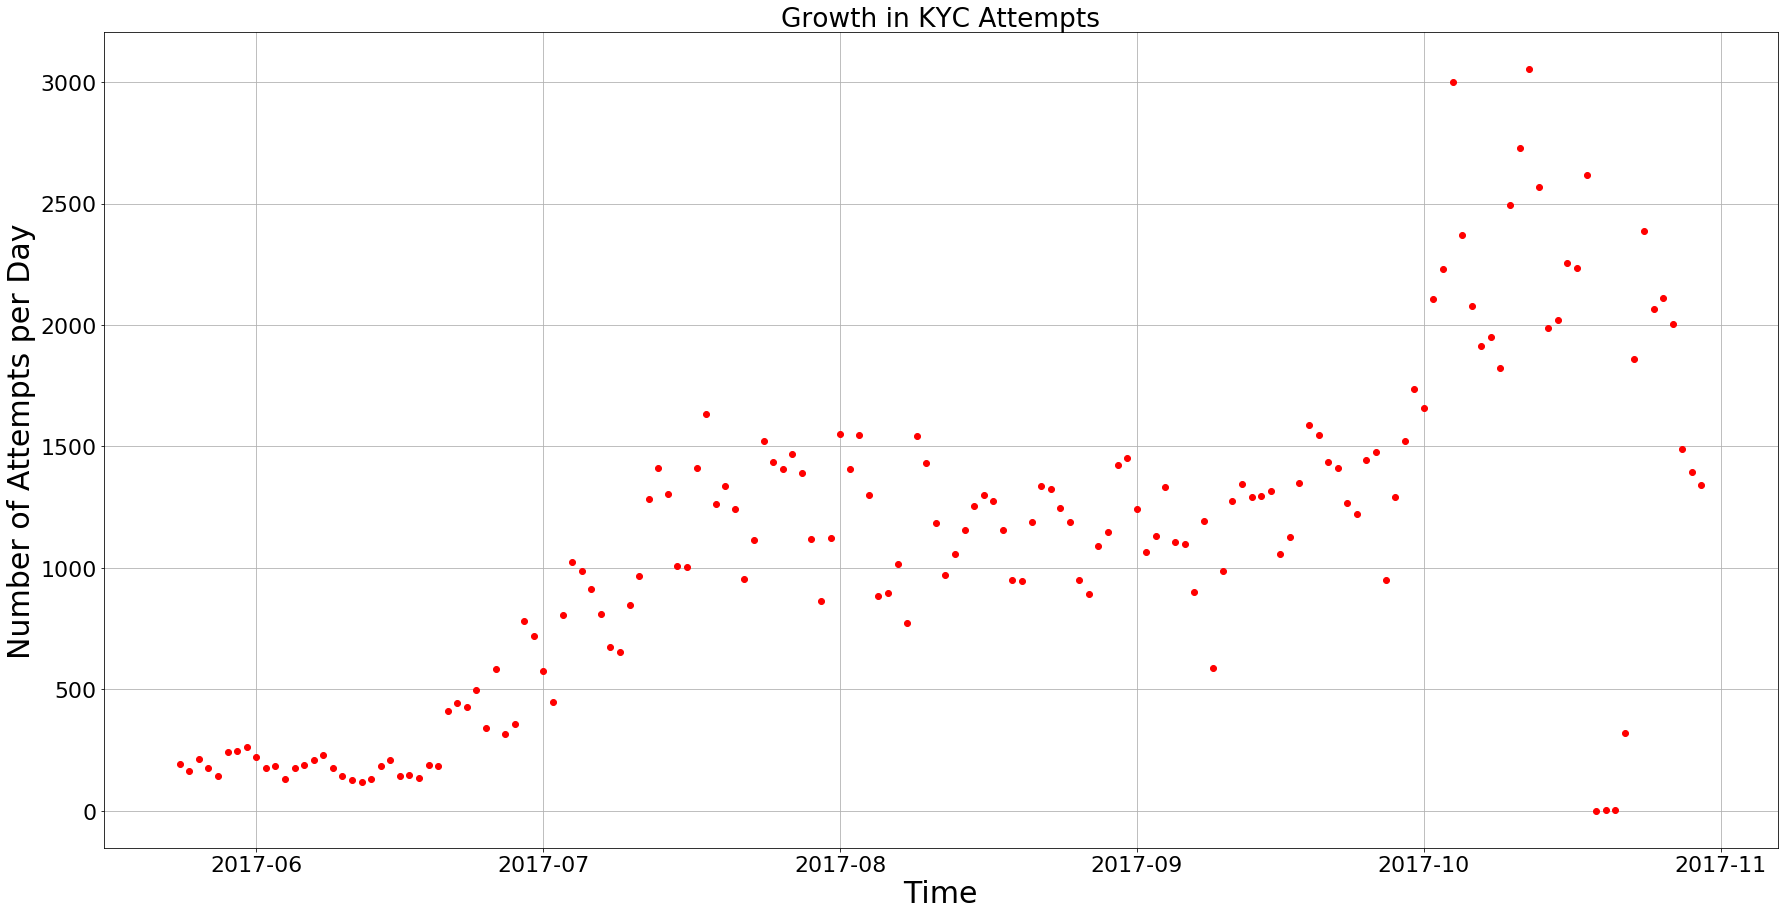

In [19]:
# Create bins for each day which store the number of attempts that day
plt.rcParams['figure.figsize'] = (30, 15)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 22})

days_in_period = pd.date_range('2017-05-24', '2017-10-31', normalize=False)
day_bins = []
for k in range(len(days_in_period)-1):
    upper = df["DOCS_created_at"] < days_in_period[k+1]
    lower = df["DOCS_created_at"] > days_in_period[k]
    day_bins.append(len(df[upper & lower]))
plt.grid(b=True)
plt.plot(days_in_period[:-1], day_bins, 'ro')
plt.ylabel("Number of Attempts per Day", fontsize=30)
plt.xlabel("Time", fontsize=30)
plt.title('Growth in KYC Attempts')
plt.show()

In [20]:
# Increase in Number of Attempts per Day is a product of growth in users and exhibits
# a positive relationship with the Document Failure Rate

# Diagnostics

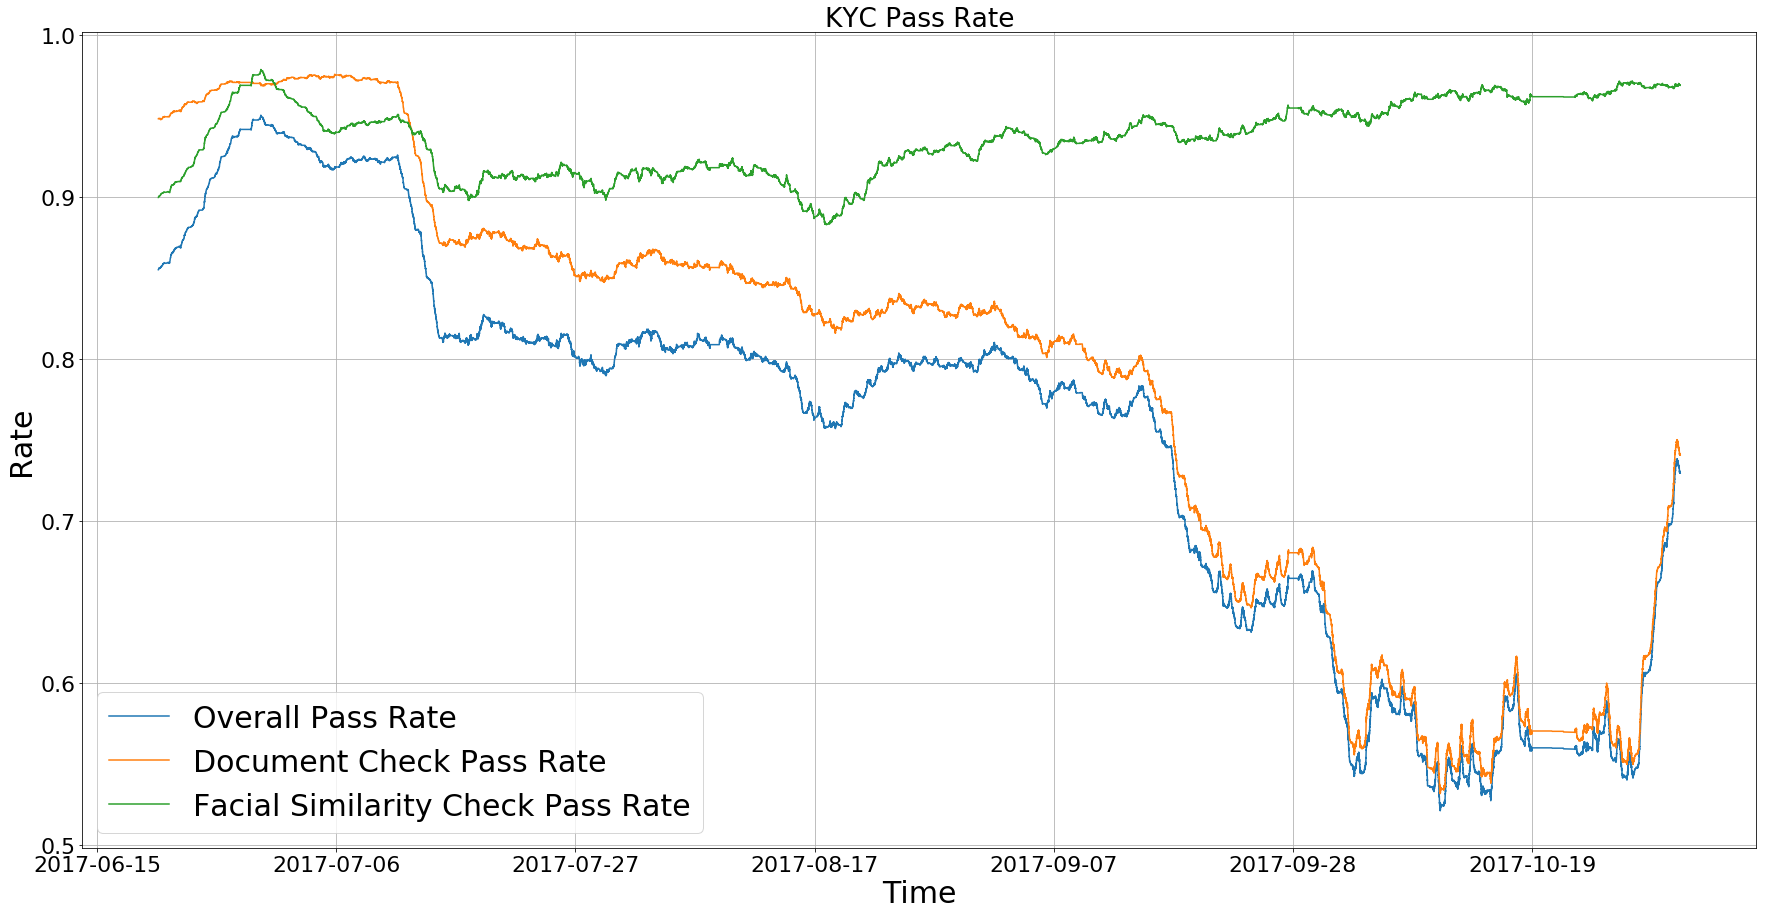

In [21]:
#Plot graphs of Overall Pass rate, Document check Pass rate, Facial Similarity check Pass rate,
# Plot the sub result, along with document failure rate. The sub result is specific to the 
# Document result providing further elucidation when it fails.

def moving_average(x,N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
# efficient moving average algorithm


def plot_ma(variables,labels,title='',start=0,N=5000):
    time =  list(df["FACE_created_at"])
    for i in range(len(variables)):
        time =  list(df["FACE_created_at"])
        y = list(variables[i].astype(int))
        ma = moving_average(y,N)
        start_index = len(time) - len(ma)
        time = time[start_index:]
        label = labels[i]
        time = time[start:]
        ma = ma[start:]
        plt.plot(time,ma,label= label.format(i=i))
    plt.grid(b=True)
    plt.legend(loc='best',prop={'size': 30})
    plt.ylabel("Rate",fontsize=30)
    plt.xlabel("Time",fontsize=30)
    plt.title(title)
    plt.show()
    
    
plot_ma([df['Pass'],docs_result,face_result],['Overall Pass Rate','Document Check Pass Rate','Facial Similarity Check Pass Rate'],'KYC Pass Rate')   

# fn to plot moving average of different rates, 
# each plot is rate of last 5000 attempts
 
# Clearly the reason the pass rate has decreased substantially in the recent period
# is wholly due to the Document Check

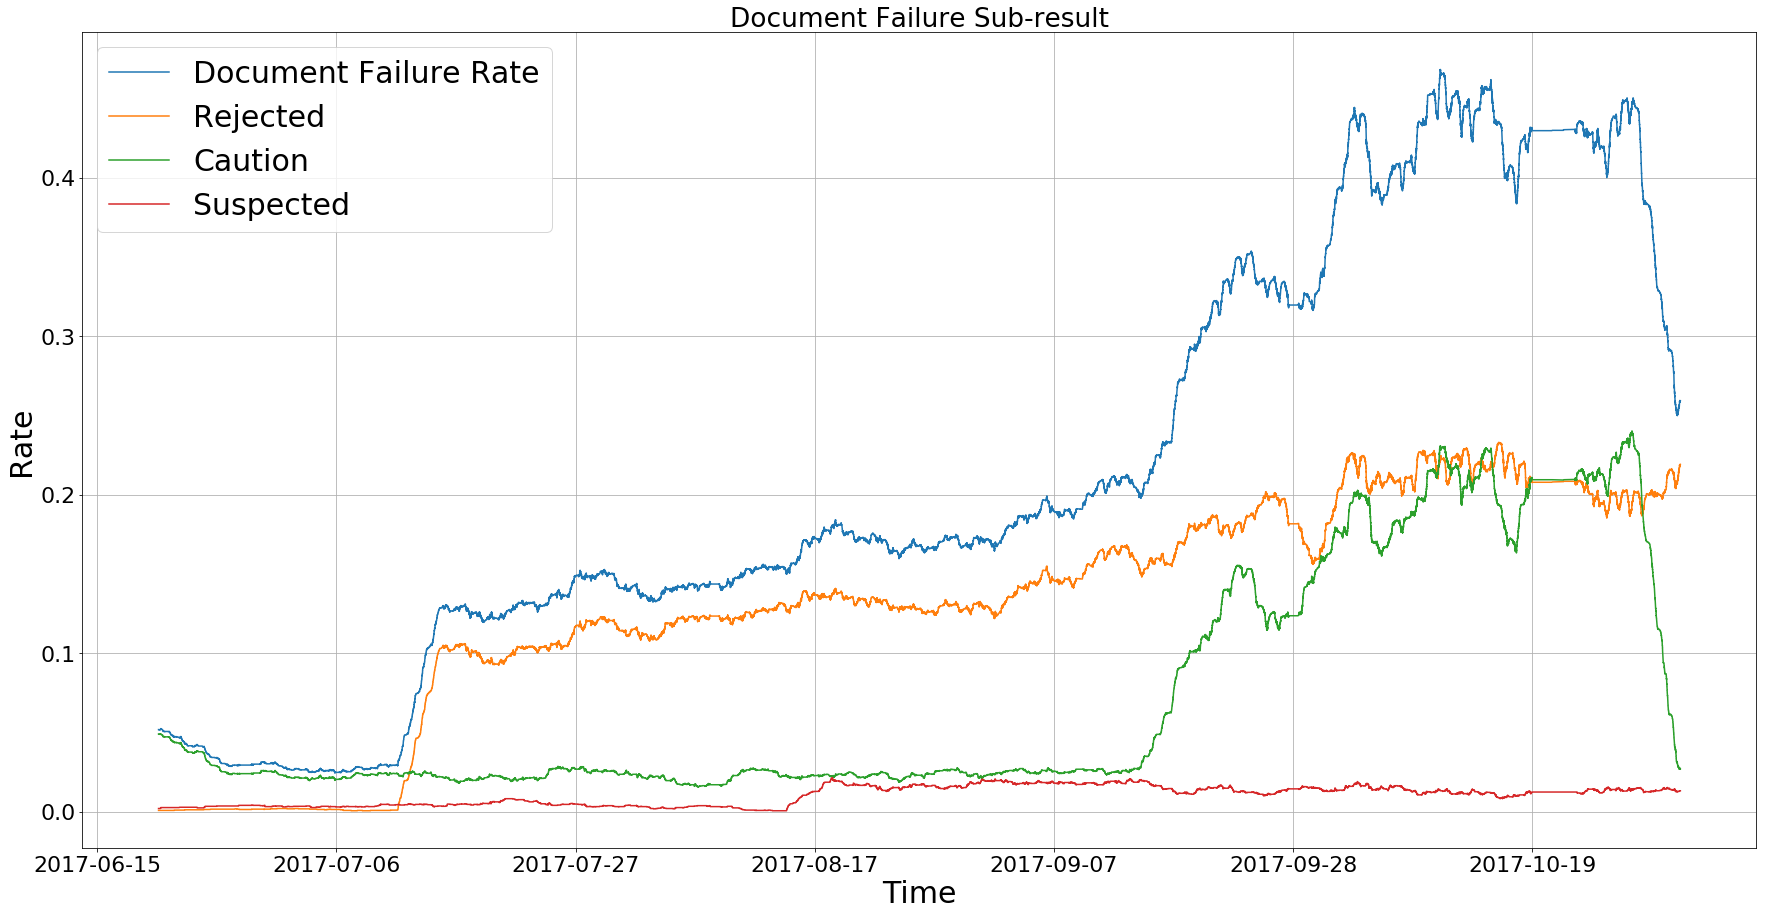

In [22]:
# Investigate the sub result when document check failure occurs. Plot against the document failure rate, as these
#sub results are specified when failure of the document check occurs

rejected = df['sub_result'] == 'rejected' 
caution = df['sub_result'] == "caution"
suspected = df['sub_result'] == 'suspected'
doc_failure = df["DOCS_result"] != "clear"

plot_ma([doc_failure,rejected,caution,suspected],['Document Failure Rate','Rejected','Caution','Suspected'],'Document Failure Sub-result')


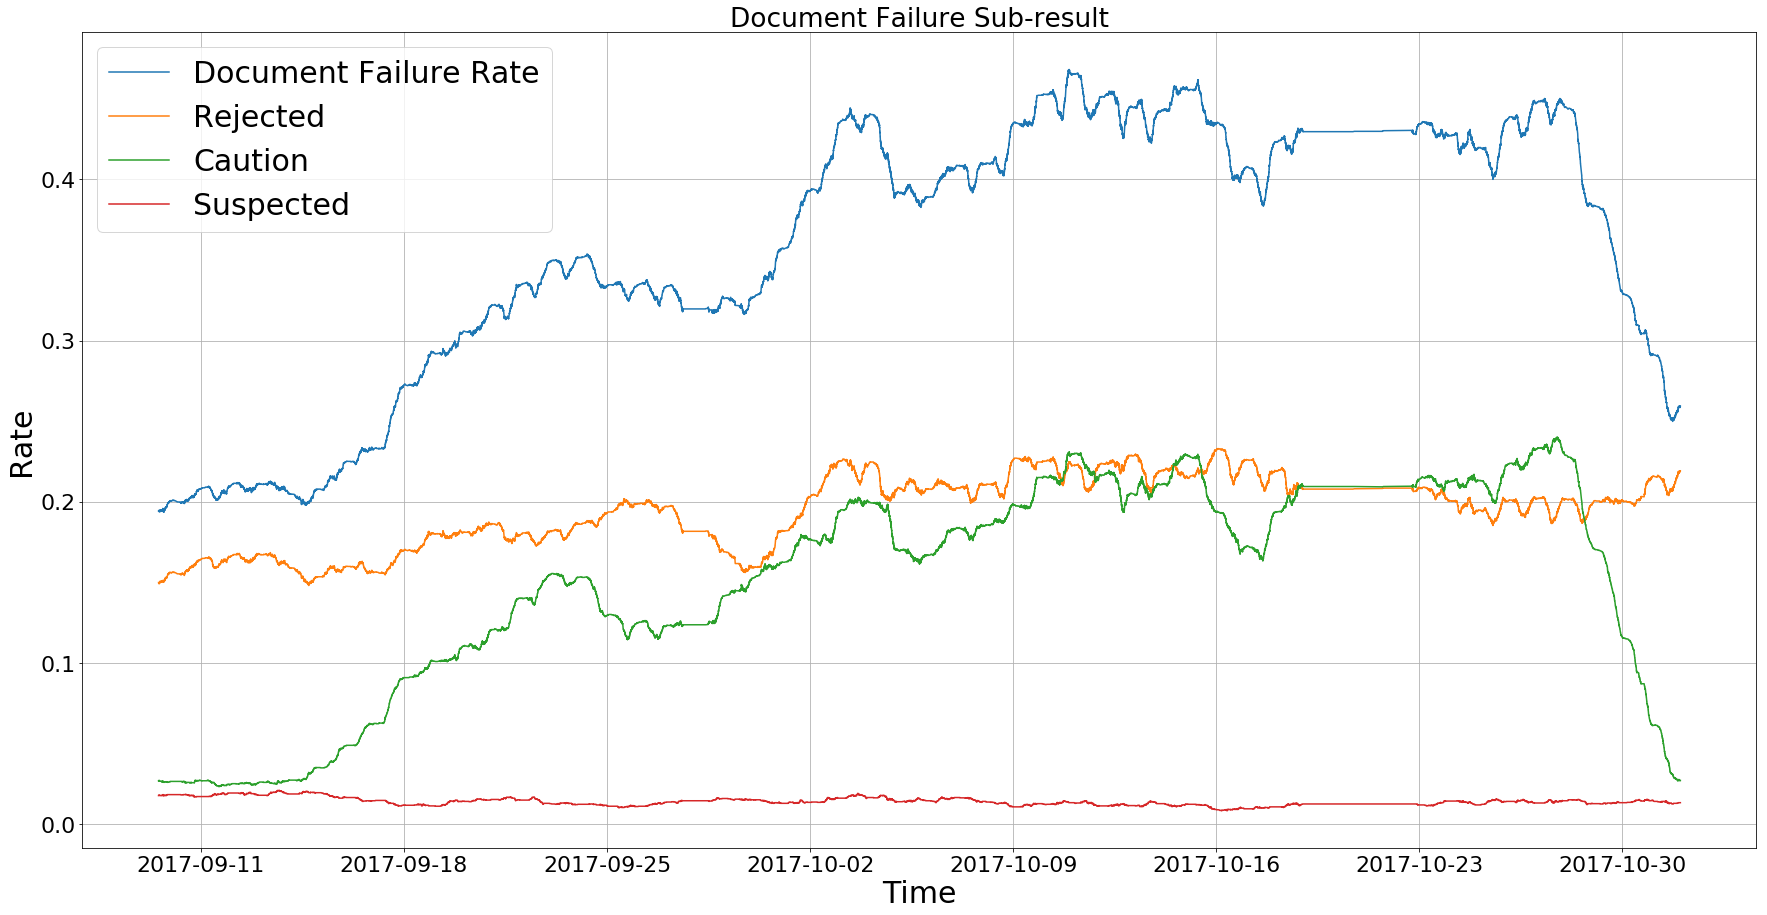

In [23]:
# Closer Inspection
plot_ma([doc_failure,rejected,caution,suspected],['Document Failure Rate','Rejected','Caution','Suspected'],'Document Failure Sub-result',85000)
# Shows the Document Failure rate was mostly driven by Rejected results until mid September 2017
#where failures due to 'Caution' results produce a large increase in the document failure rate

# Document Report Breakdown

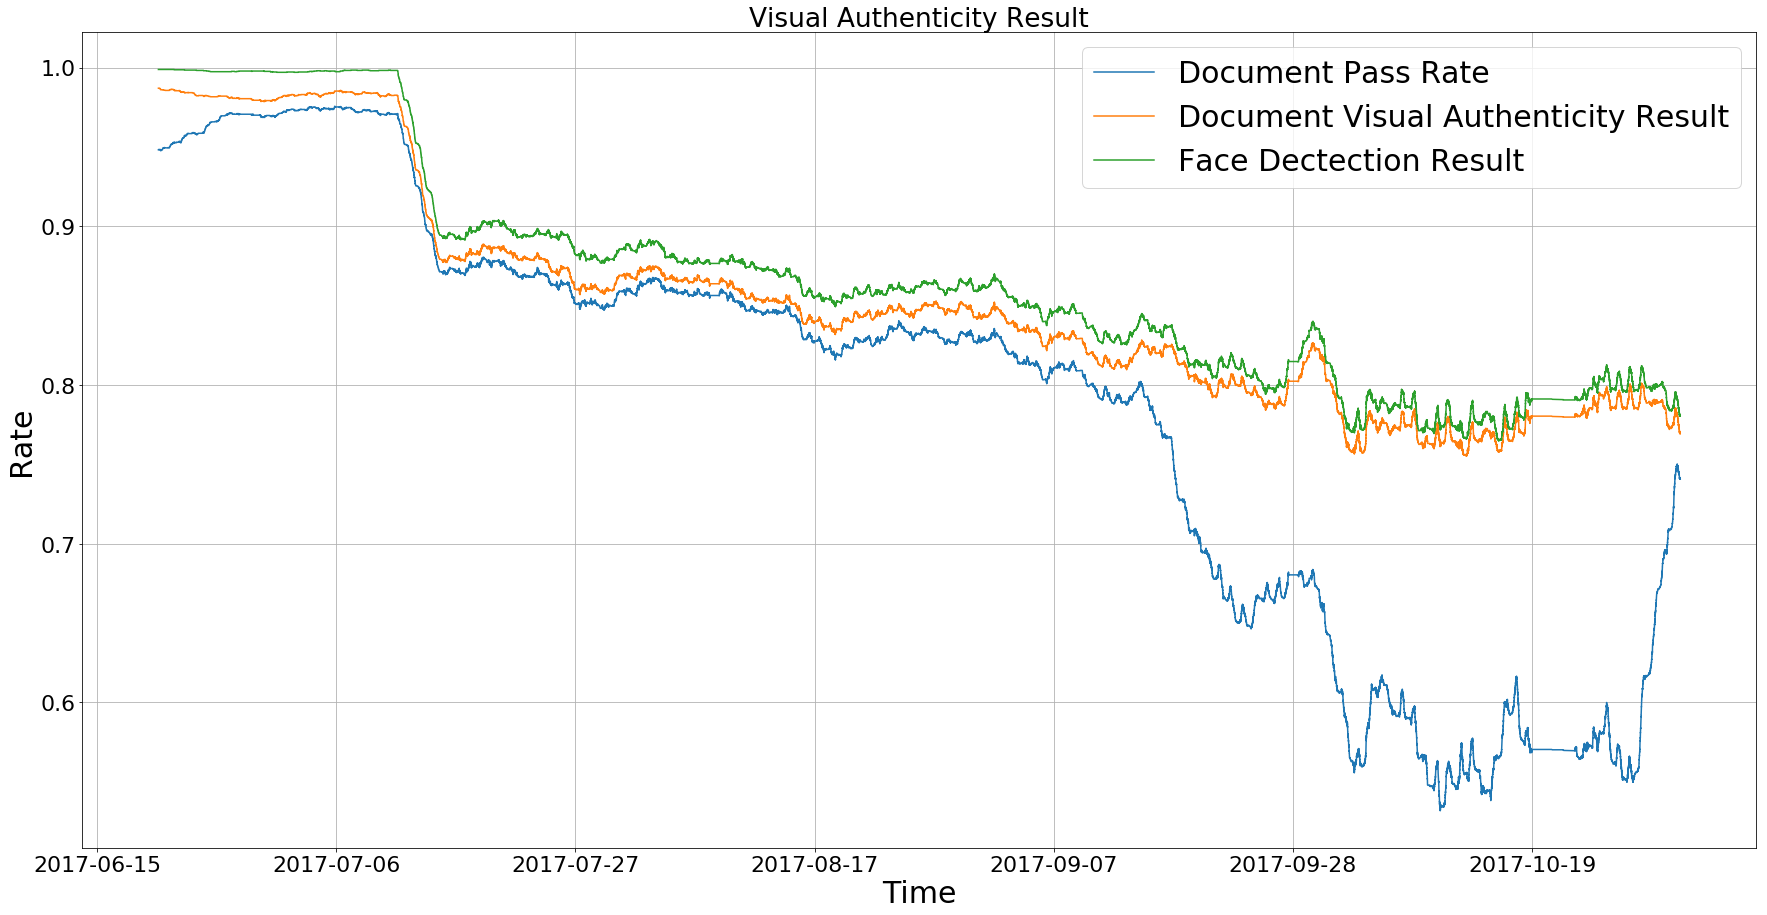

In [24]:
#The document report comprises data integrity, visual authenticity 
#and police record checks. It checks the internal and external consistency of the most
#recent identity document provided by the applicant to identify potential discrepancies.

def plot_ma_breakdown(variables,labels,title='',start=0,N=5000):
    for result in range(len(variables)):
        variables[result] = df[variables[result]] == "clear"
    plot_ma(variables,labels,title,start,N)

# Visual Authenticity Result: face detection result is a component
plot_ma_breakdown(['DOCS_result','visual_authenticity_result','face_detection_result'],['Document Pass Rate','Document Visual Authenticity Result','Face Dectection Result'],'Visual Authenticity Result') 


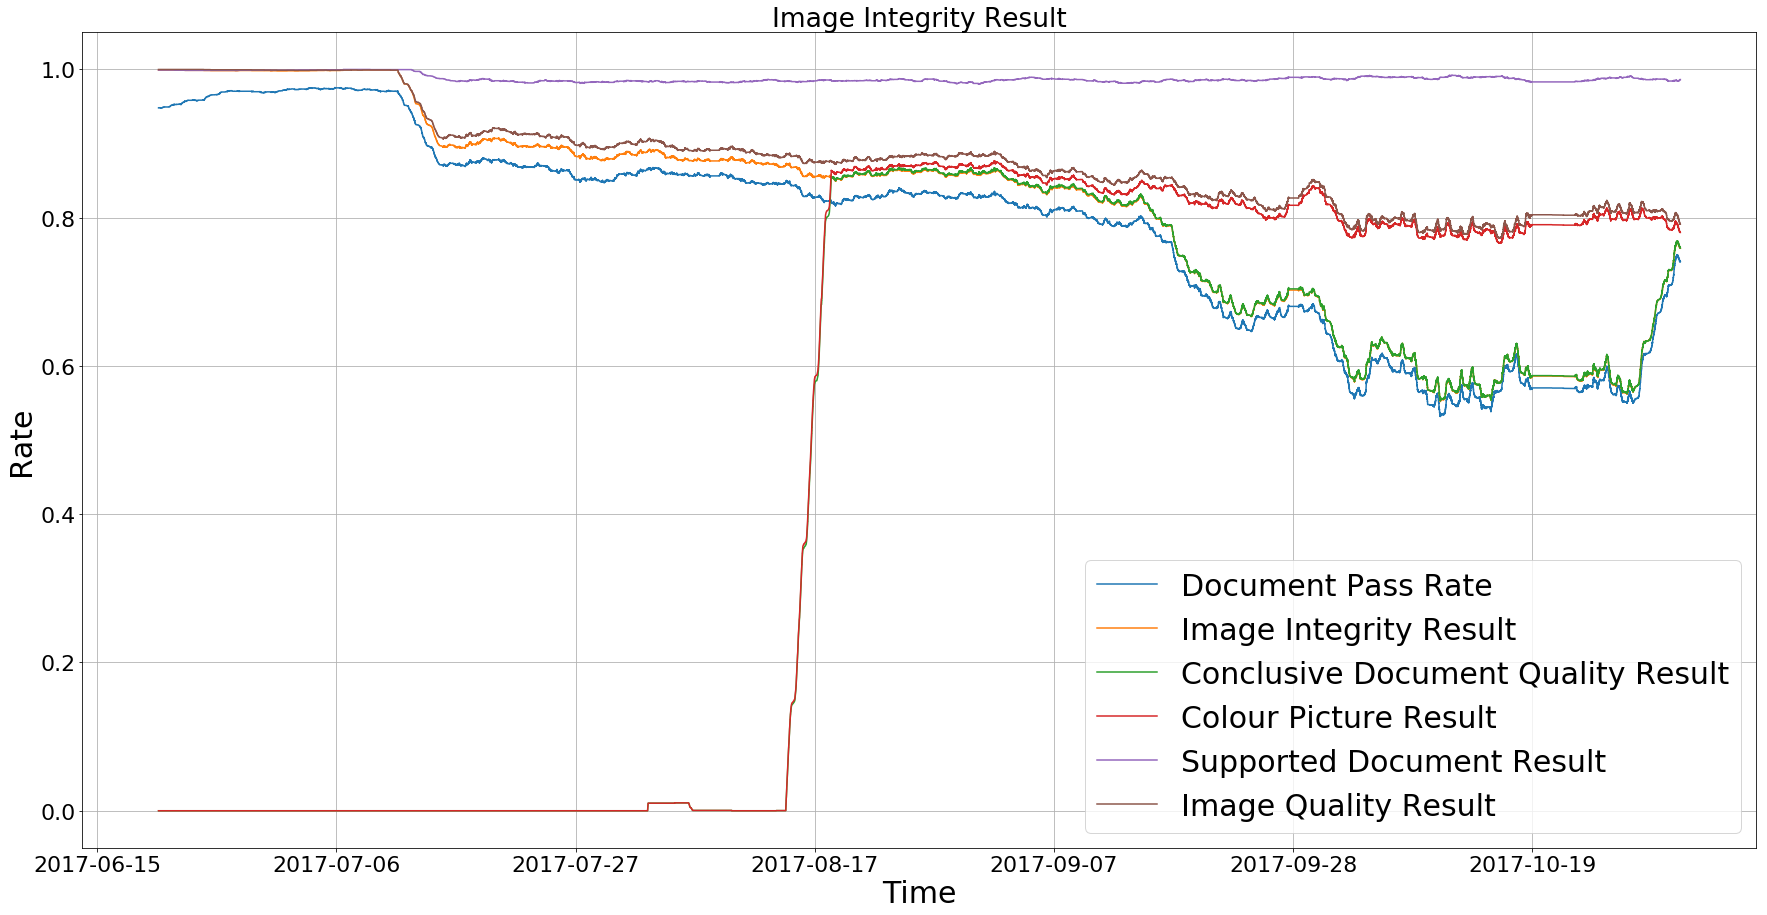

In [25]:
# Look into Image Integrity Result: Supported Document, Image Quality, Colour Picture 
# and Conclusive Document Quality are components
plot_ma_breakdown(['DOCS_result','image_integrity_result','conclusive_document_quality_result','colour_picture_result','supported_document_result','image_quality_result'],['Document Pass Rate','Image Integrity Result','Conclusive Document Quality Result','Colour Picture Result','Supported Document Result','Image Quality Result'],'Image Integrity Result')
                  
                  
                 
        

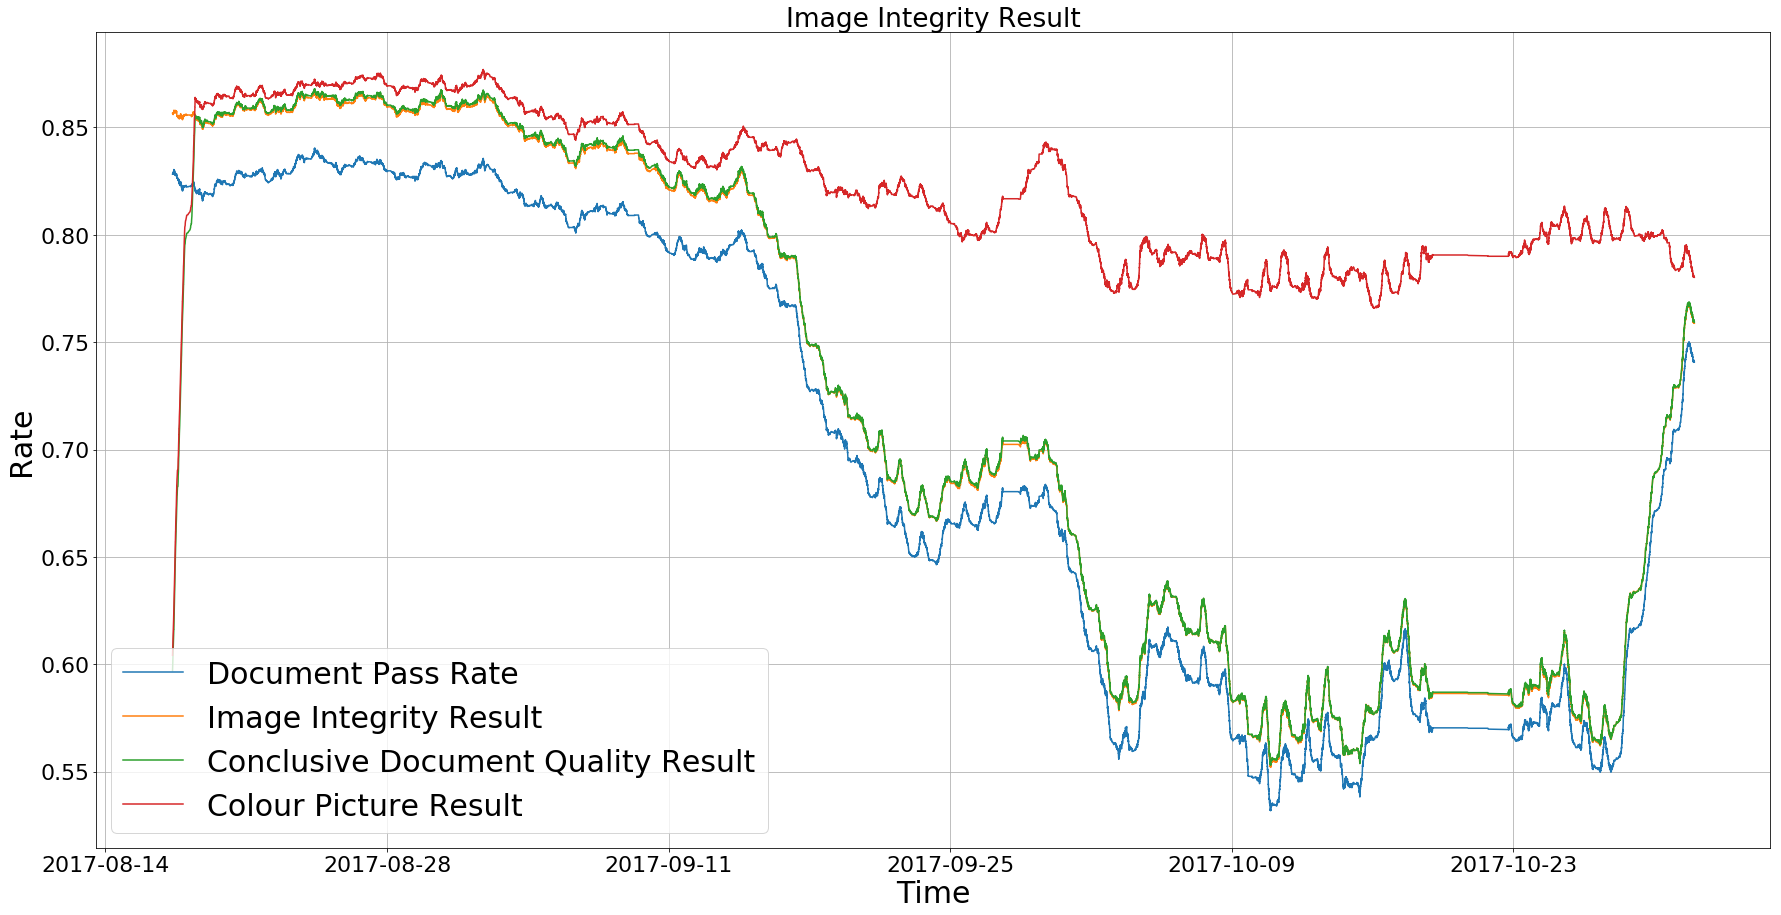

In [26]:
plot_ma_breakdown(['DOCS_result','image_integrity_result','conclusive_document_quality_result','colour_picture_result'],['Document Pass Rate','Image Integrity Result','Conclusive Document Quality Result','Colour Picture Result'],'Image Integrity Result',58400)

In [27]:
# Image Integrity 'Asserts whether the document was of sufficient quality to verify'
# Specifically Conclusive Document Quality is directly correlated to the decrease in the Document
#Pass Rate, incidentally this drop coincides with the appearance of the Conclusive Document Result
#and Colour Picture Results starting to register results in August.

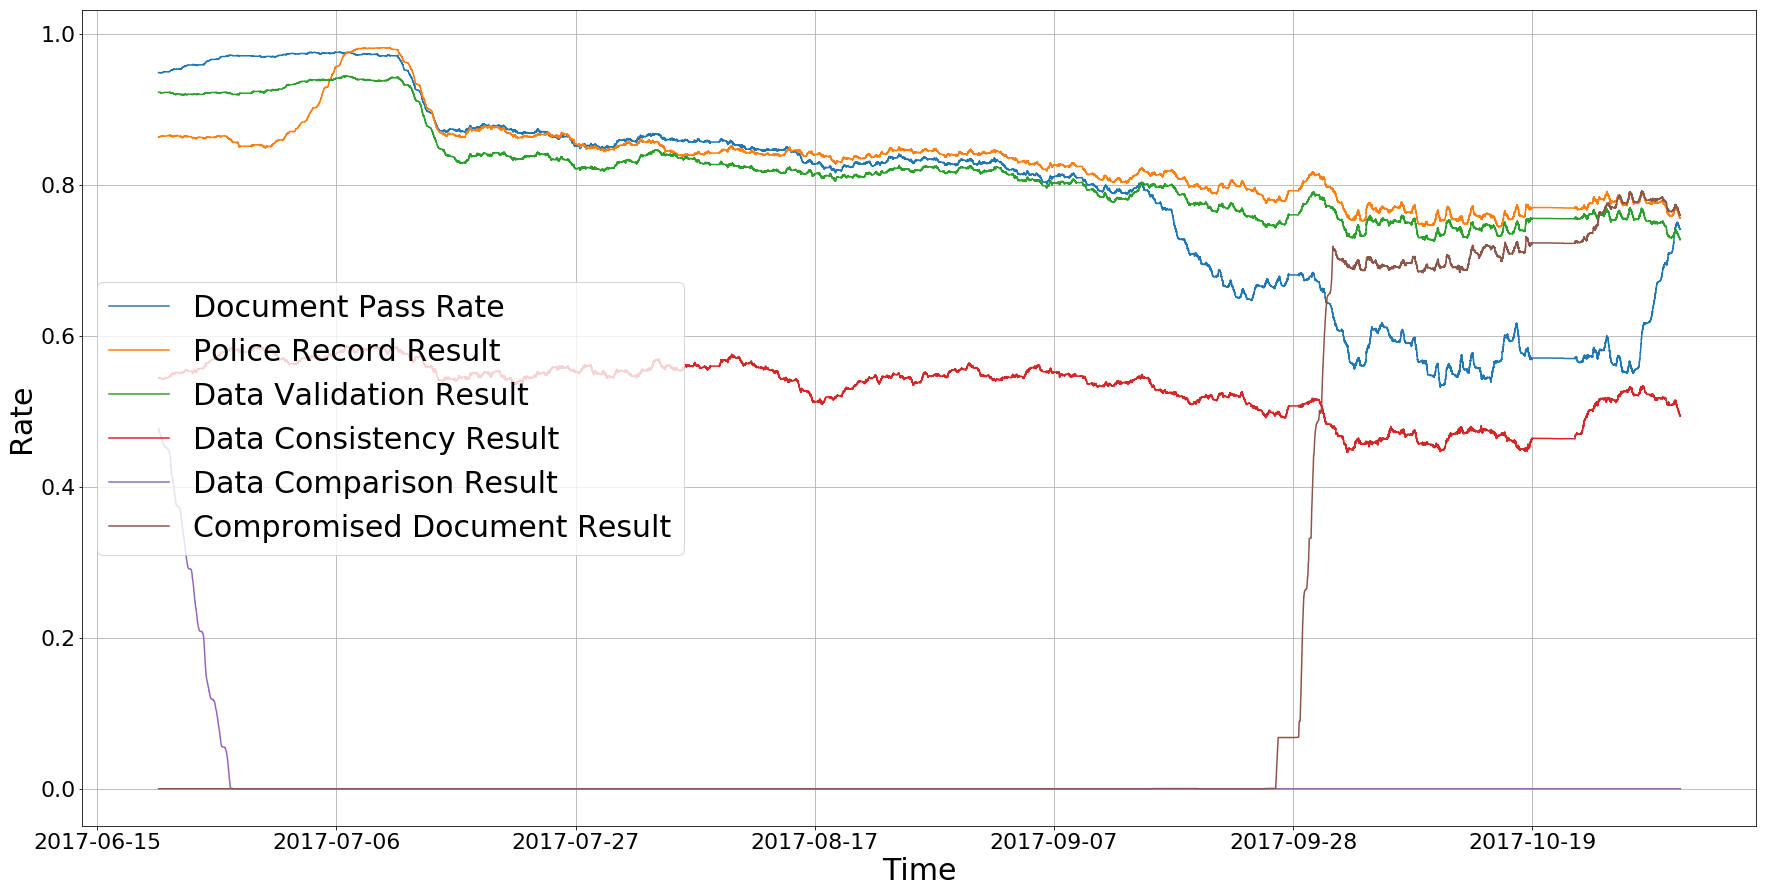

In [28]:

plot_ma_breakdown(['DOCS_result','police_record_result','data_validation_result','data_consistency_result','data_comparison_result','compromised_document_result'],['Document Pass Rate','Police Record Result','Data Validation Result','Data Consistency Result','Data Comparison Result','Compromised Document Result'])
# Other Document Report Breakdown results do not contribute significantly to failure

## Analysis of the Document Report Field: 'Properties'

In [29]:
# Convert to python Dictionary
df['DOCS_properties'] = df['DOCS_properties'].apply(lambda element: ast.literal_eval(element))

In [30]:
def find_key_list():
    a = []
    for i in df['DOCS_properties']:
        for j in i:
            if j not in a:
                a.append(j)
    return a
key_list = find_key_list()
# find list of fields in properties
def split(index, variable):
    dic = df['DOCS_properties'][index]
    if variable in dic:
            return dic[variable]
# Create a separate column for each field in properties: 'gender', 'document_type' etc., with correct result for each applicant
def separate_columns_for_keys(key_list):
    for i in key_list:
        df[i]= df.index
        df[i] = df[i].apply(lambda index: split(index,i))
separate_columns_for_keys(key_list)

In [31]:
print(key_list)

['gender', 'document_type', 'date_of_expiry', 'issuing_country', 'nationality', 'issuing_date', 'issuing_state', 'document_version']


In [32]:
df.iloc[0,:]

Unnamed: 0                                                                        49293
user_id                                                3aee7324dfba466d96888ff9ad185b58
FACE_result                                                                       clear
face_comparison_result                                                            clear
FACE_created_at                                                     2017-05-23 15:13:02
facial_image_integrity_result                                                     clear
visual_authenticity_result                                                        clear
FACE_properties                                                         {'score': 0.73}
FACE_attempt_id                                        d21de828c5514277aaedb316edc6c48c
DOCS_result                                                                       clear
image_integrity_result                                                            clear
face_detection_result           

In [33]:
# quick scan of properties
#for i in key_list:
    #print (df[i].value_counts())

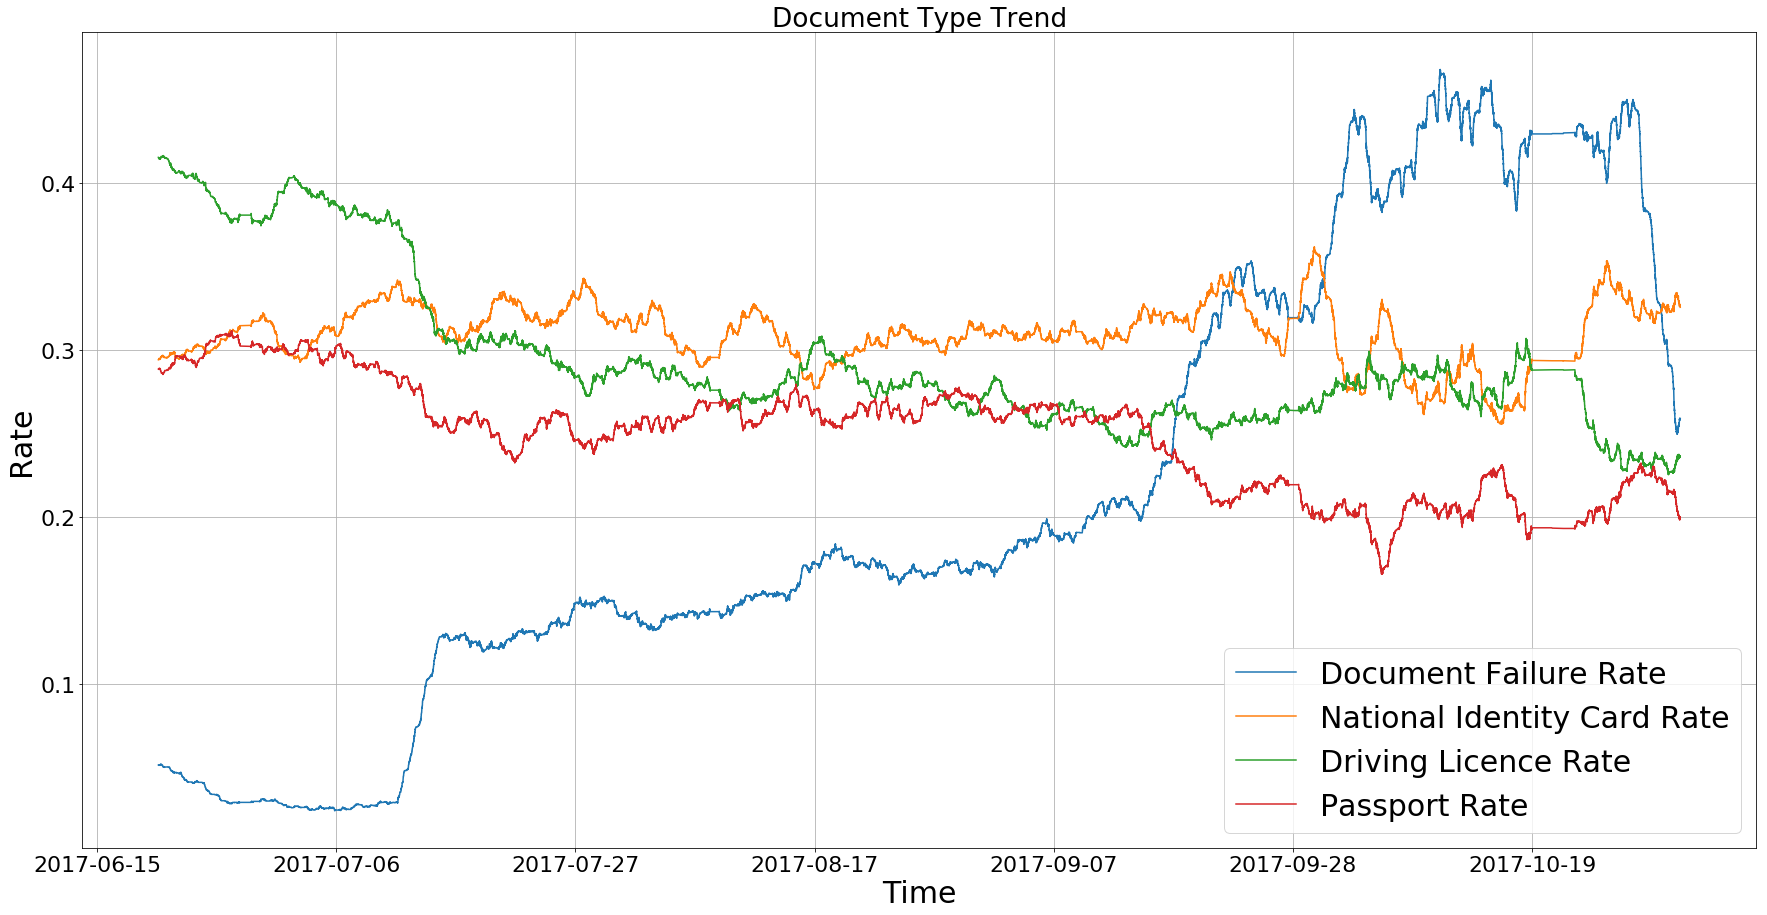

In [34]:
# There could be a problem of Image integrity with a particular document type or documents
# from a specific nation, although the value_counts above are admittedly too small

# Inspection of Trend of Document Types and Document Failure Rate

national_identity_card = df['document_type'] == 'national_identity_card' 
driving_licence = df['document_type'] == 'driving_licence'
passport = df['document_type'] == 'passport'

plot_ma([doc_failure,national_identity_card,driving_licence,passport],['Document Failure Rate','National Identity Card Rate','Driving Licence Rate','Passport Rate'],'Document Type Trend')
# No relationship

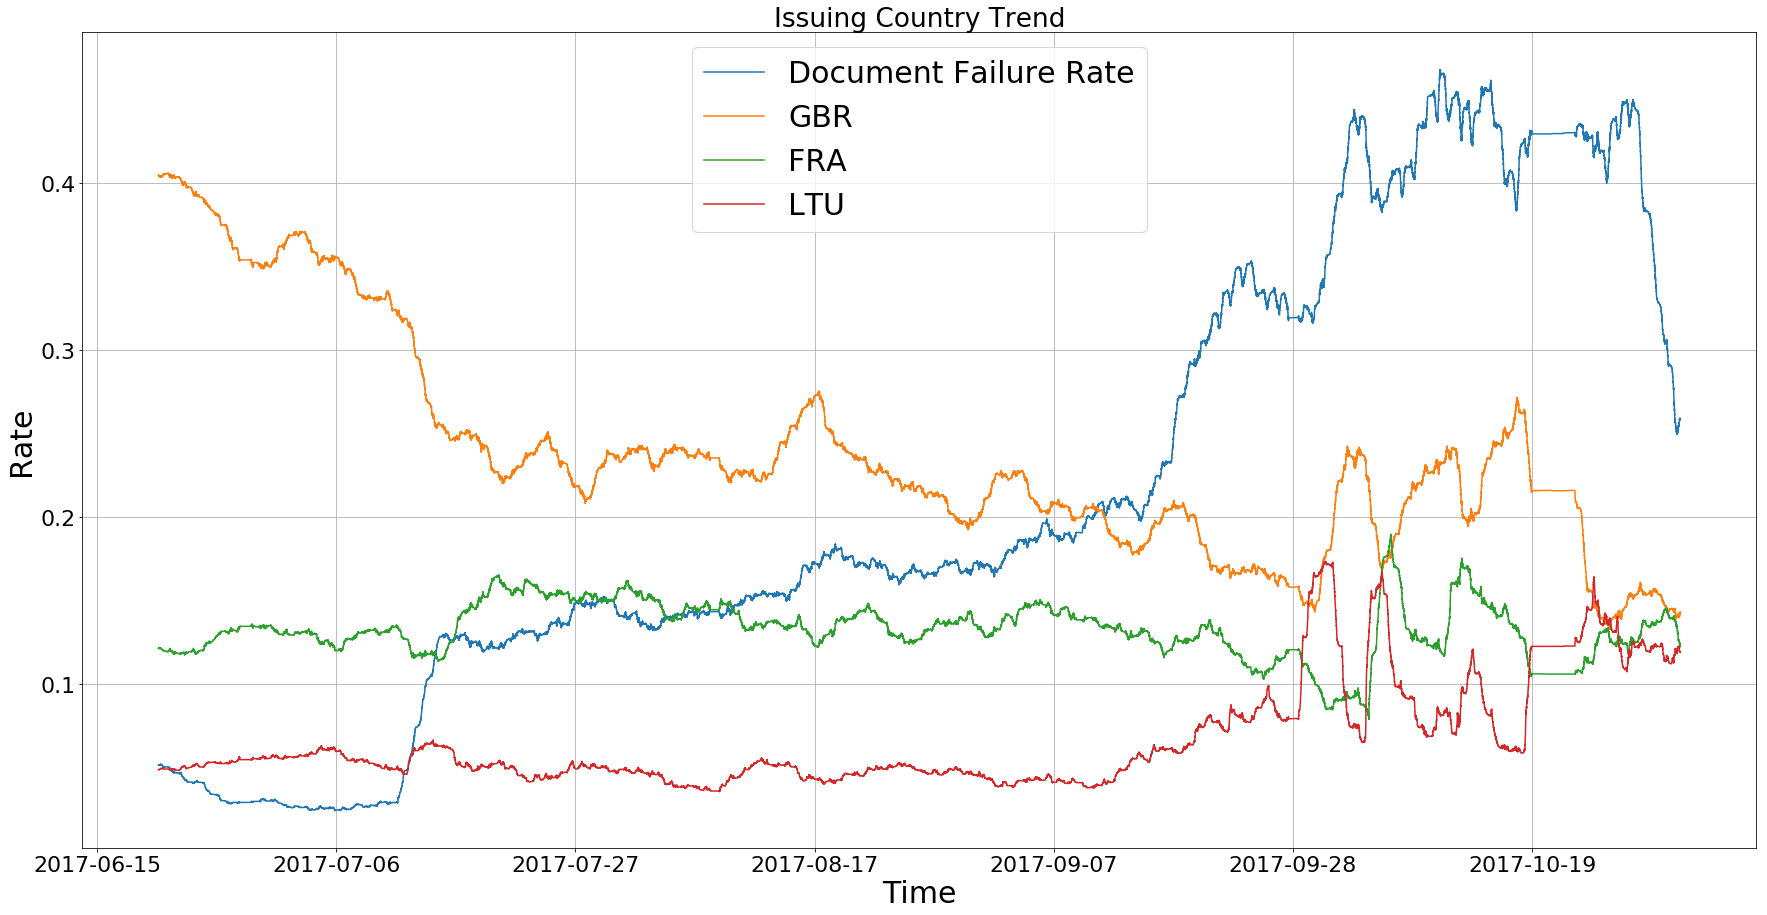

In [35]:
# Inspection of Trend of Issuing Country and Document Failure Rate
GBR = df['issuing_country'] == 'GBR' 
FRA = df['issuing_country'] == 'FRA'
LTU = df['issuing_country'] == 'LTU'


plot_ma([doc_failure,GBR,FRA,LTU],['Document Failure Rate','GBR','FRA','LTU'],'Issuing Country Trend')
# No relationship,similarly there is no relationship for other fields. I tested all the others

## Null results

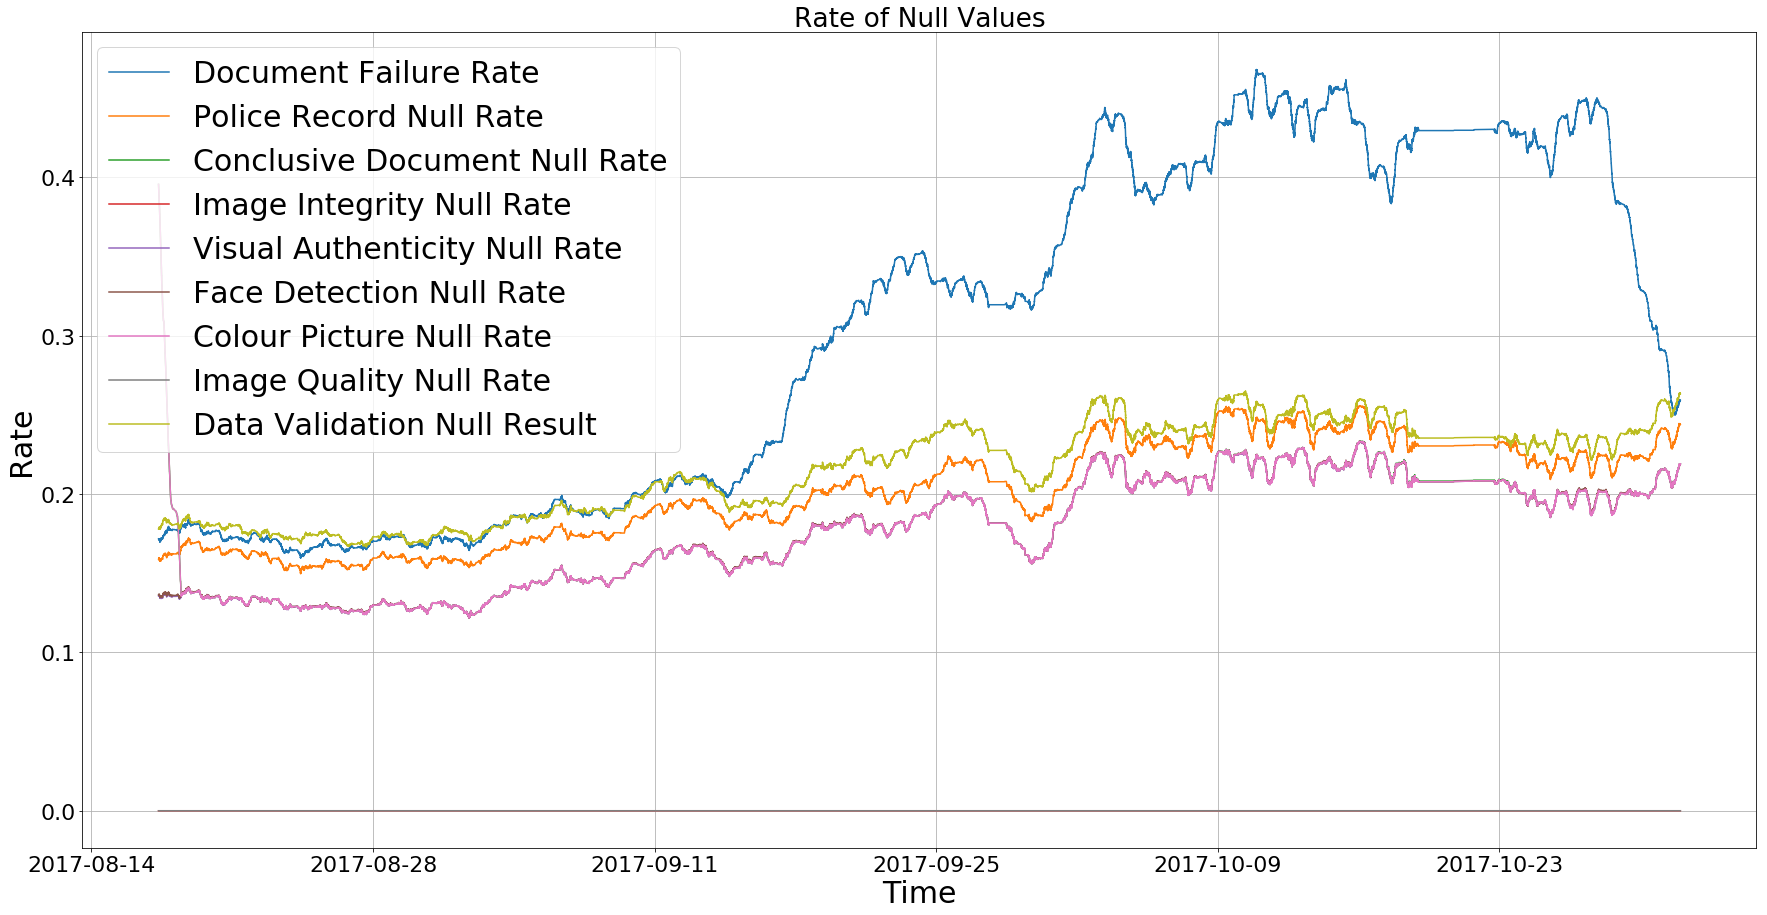

In [36]:
# An increase of the API not being able to input results for certain checks
#could lead to Document Failure
def plot_ma_Null(variables,labels,start=0,N=5000):
    for result in range(len(variables)):
        if result > 0:
            variables[result] = df[variables[result]].isnull()
    plot_ma(variables,labels,start,N)
W = [doc_failure,'police_record_result','conclusive_document_quality_result','image_integrity_result','visual_authenticity_result','face_detection_result','colour_picture_result','image_quality_result','data_validation_result']
plot_ma_Null(W,['Document Failure Rate','Police Record Null Rate','Conclusive Document Null Rate','Image Integrity Null Rate', 'Visual Authenticity Null Rate','Face Detection Null Rate','Colour Picture Null Rate','Image Quality Null Rate','Data Validation Null Result'],'Rate of Null Values',58400)
# Colour picture and conclusive document quality which are sub-checks Image Integrity
# had null results and then conclusive document quality produced values coinciding with the increase in the Document Failure Rate


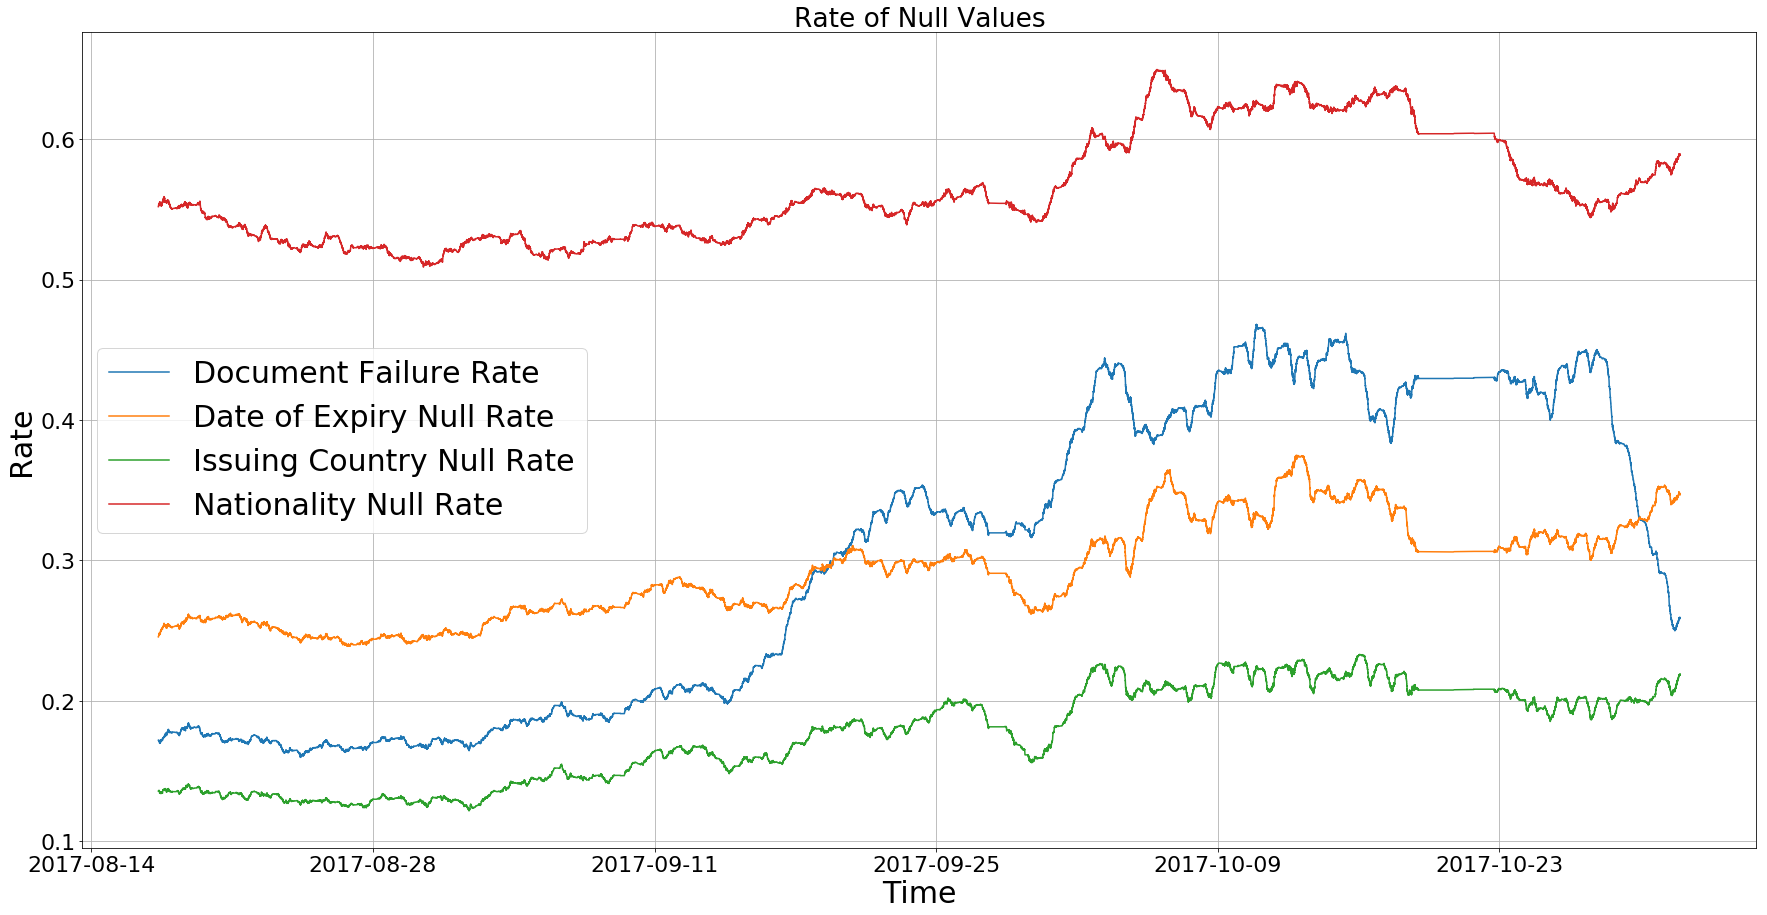

In [37]:
plot_ma_Null([doc_failure,'date_of_expiry','issuing_country','nationality'],['Document Failure Rate','Date of Expiry Null Rate','Issuing Country Null Rate','Nationality Null Rate'],'Rate of Null Values',58400)
